In [1]:
import os
import pandas as pd

model_names = [
    "unet_base",
    "unet_conditional",
    "restormer",
    "pix2pix",
    "diffusion_sr3",
]
datasets = ["A", "B", "C"]
colors = {"A": "blue", "B": "red", "C": "green"}
metrics = ["psnr", "ssim", "psnr_worst", "ssim_worst", "ocr_digit", "ocr_plate"]

# Load and tag
df_list = []
for ds in datasets:
    root = os.path.join("results", ds)
    for model in model_names:
        fp = os.path.join(root, f"{model}.csv")
        if os.path.isfile(fp):
            tmp = pd.read_csv(fp)
            tmp["model"] = model
            tmp["dataset"] = ds
            df_list.append(tmp)
        else:
            print(f"Skipping missing file: {fp}")

df_all = pd.concat(df_list, ignore_index=True)

# Aggregate means
df_mean = df_all.groupby(["model", "dataset", "alpha", "beta"], as_index=False)[metrics].mean()

# Round for readability
df_mean[metrics] = df_mean[metrics].round(
    {
        "psnr": 3,
        "ssim": 5,
        "psnr_worst": 3,
        "ssim_worst": 5,
        "ocr_digit": 3,
        "ocr_plate": 3,
    }
)

# Reorder columns
df_mean = df_mean[["model", "dataset", "alpha", "beta"] + metrics]

# enforce categorical order and sort
df_mean["model"] = pd.Categorical(df_mean["model"], categories=model_names, ordered=True)
df_mean["dataset"] = pd.Categorical(df_mean["dataset"], categories=datasets, ordered=True)

df_mean = df_mean.sort_values(by=["model", "dataset", "alpha", "beta"], ignore_index=True)

print(df_mean.head())
print(df_mean.tail())

       model dataset  alpha  beta    psnr     ssim  psnr_worst  ssim_worst  \
0  unet_base       A      0     0  49.331  0.99596      48.139     0.99600   
1  unet_base       A      0     1  49.282  0.99580      48.088     0.99564   
2  unet_base       A      0     2  49.526  0.99584      48.590     0.99572   
3  unet_base       A      0     3  49.350  0.99579      48.020     0.99584   
4  unet_base       A      0     4  49.276  0.99582      48.104     0.99586   

   ocr_digit  ocr_plate  
0        1.0        1.0  
1        1.0        1.0  
2        1.0        1.0  
3        1.0        1.0  
4        1.0        1.0  
                model dataset  alpha  beta    psnr     ssim  psnr_worst  \
121495  diffusion_sr3       C     89    85  13.509  0.72688      10.293   
121496  diffusion_sr3       C     89    86  13.717  0.72951      10.347   
121497  diffusion_sr3       C     89    87  13.077  0.72265       9.844   
121498  diffusion_sr3       C     89    88  13.641  0.76249      10.422   


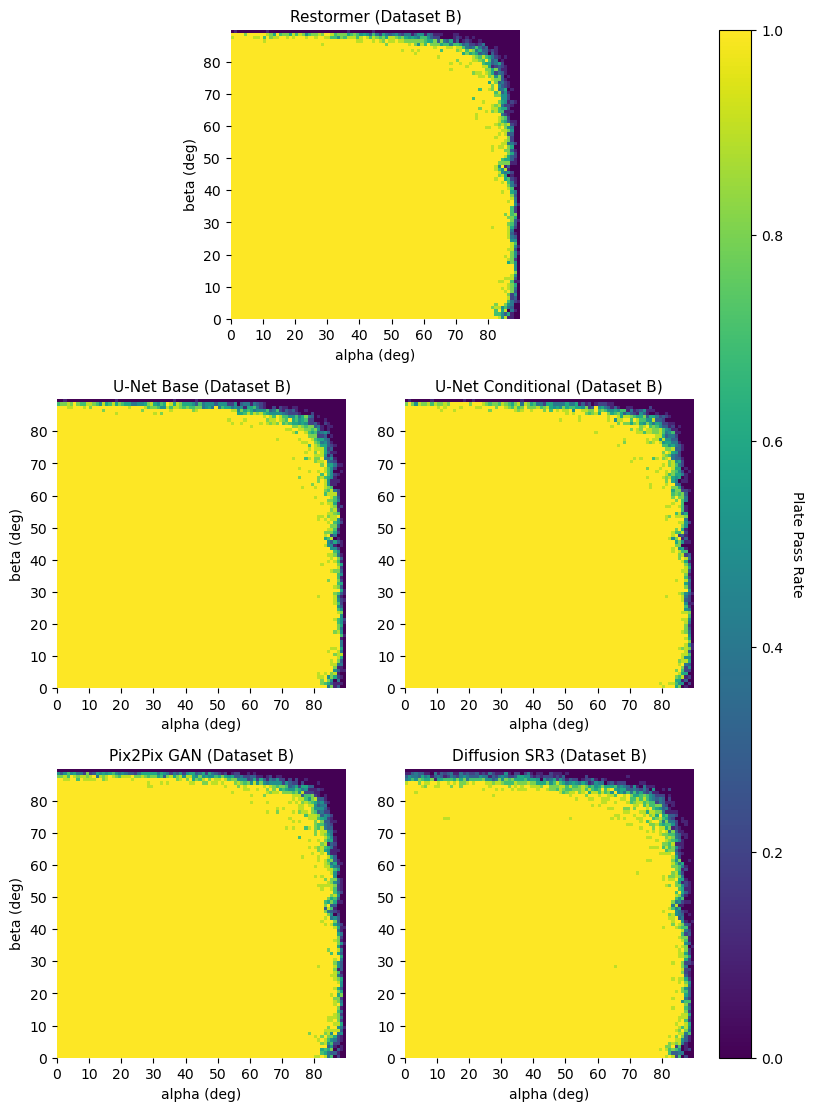

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

# Assume df_mean is already in memory as per earlier aggregation steps
# Filter to Dataset B
df_B = df_mean[df_mean["dataset"] == "B"].copy()

# Prepare sorted alpha/beta axes
alpha_vals = np.sort(df_B["alpha"].unique())
beta_vals = np.sort(df_B["beta"].unique())

# Compute tick positions and labels at every 10°
alpha_ticks = [i for i, a in enumerate(alpha_vals) if a % 10 == 0]
beta_ticks = [i for i, b in enumerate(beta_vals) if b % 10 == 0]
alpha_labels = [f"{a}" for a in alpha_vals if a % 10 == 0]
beta_labels = [f"{b}" for b in beta_vals if b % 10 == 0]


# Helper to build the OCR plate-pass matrix for a given model
def ocr_matrix(model: str) -> np.ndarray:
    pivot = (
        df_B[df_B["model"] == model]
        .pivot(index="beta", columns="alpha", values="ocr_plate")
        .reindex(index=beta_vals, columns=alpha_vals)
    )
    return pivot.to_numpy()


# Common drawing function
def draw_heat(ax, mat, title):
    sns.heatmap(
        mat, ax=ax, cmap="viridis", vmin=0, vmax=1, cbar=False, xticklabels=False, yticklabels=False, square=True
    )
    ax.invert_yaxis()
    ax.set_title(title, fontsize=11)
    # set ticks
    ax.set_xticks(alpha_ticks)
    ax.set_xticklabels(alpha_labels, rotation=0)
    ax.set_yticks(beta_ticks)
    ax.set_yticklabels(beta_labels, rotation=0)


# Build figure with constrained_layout
fig = plt.figure(figsize=(8, 11), constrained_layout=True)
gs = gridspec.GridSpec(3, 3, figure=fig, width_ratios=[1, 1, 0.1], height_ratios=[1, 1, 1])

# Row 1: Restormer spanning two cols
ax0 = fig.add_subplot(gs[0, 0:2])
draw_heat(ax0, ocr_matrix("restormer"), "Restormer (Dataset B)")

# Row 2
ax1 = fig.add_subplot(gs[1, 0])
draw_heat(ax1, ocr_matrix("unet_base"), "U-Net Base (Dataset B)")
ax2 = fig.add_subplot(gs[1, 1])
draw_heat(ax2, ocr_matrix("unet_conditional"), "U-Net Conditional (Dataset B)")

# Row 3
ax3 = fig.add_subplot(gs[2, 0])
draw_heat(ax3, ocr_matrix("pix2pix"), "Pix2Pix GAN (Dataset B)")
ax4 = fig.add_subplot(gs[2, 1])
draw_heat(ax4, ocr_matrix("diffusion_sr3"), "Diffusion SR3 (Dataset B)")

# Shared colorbar in the third column
cax = fig.add_subplot(gs[:, 2])
cbar = fig.colorbar(ax0.collections[0], cax=cax)
cbar.set_label("Plate Pass Rate", rotation=270, labelpad=15)

# Axis labels
for ax in (ax0, ax1, ax3):
    ax.set_ylabel("beta (deg)")
for ax in (ax0, ax1, ax2, ax3, ax4):
    ax.set_xlabel("alpha (deg)")


plt.show()

In [3]:
import numpy as np


def compute_recoverability_boundary_and_auc(df, T):
    """
    Given a DataFrame `df` with columns ['alpha','beta','ocr_plate']
    and a threshold T in [0,1], compute:
      1) the recoverability boundary as a list of (alpha,beta) points
      2) the symmetric boundary-AUC

    Returns:
      boundary: list of (alpha, beta) tuples tracing the outer edge
      auc: float in [0,1]
    """
    alpha_vals = np.arange(0, 90)
    beta_vals = np.arange(0, 90)
    grid_area = 89 * 89

    # Build binary recoverability grid
    pivot = df.pivot(index="beta", columns="alpha", values="ocr_plate").reindex(
        index=beta_vals, columns=alpha_vals, fill_value=0
    )
    rec = (pivot.values >= T).astype(int)

    # Axis-wise maxima
    beta_max_alpha = [beta_vals[rec[:, j] == 1].max() if rec[:, j].any() else 0 for j in range(len(alpha_vals))]
    alpha_max_beta = [alpha_vals[rec[i, :] == 1].max() if rec[i, :].any() else 0 for i in range(len(beta_vals))]

    # Unified stitching of the two halves
    boundary = []

    #   C1: for each alpha (0-89), include (alpha, beta_max_alpha) whenever beta_max_alpha >= alpha
    for alpha, b in zip(alpha_vals, beta_max_alpha):
        if b >= alpha:
            boundary.append((int(alpha), int(b)))

    #   C2: for each beta in reverse (89-0), include (alpha_max_beta, beta) whenever alpha_max_beta >= beta
    for beta, a in zip(beta_vals[::-1], alpha_max_beta[::-1]):
        if a >= beta:
            boundary.append((int(a), int(beta)))

    # Compute directional areas and symmetric AUC
    auc_bxa = np.trapz(beta_max_alpha, x=alpha_vals)
    auc_axb = np.trapz(alpha_max_beta, x=beta_vals)
    auc = 0.5 * (auc_bxa + auc_axb) / grid_area

    return boundary, auc

######################################################################################  
Single dataset  
###################################################################################### 

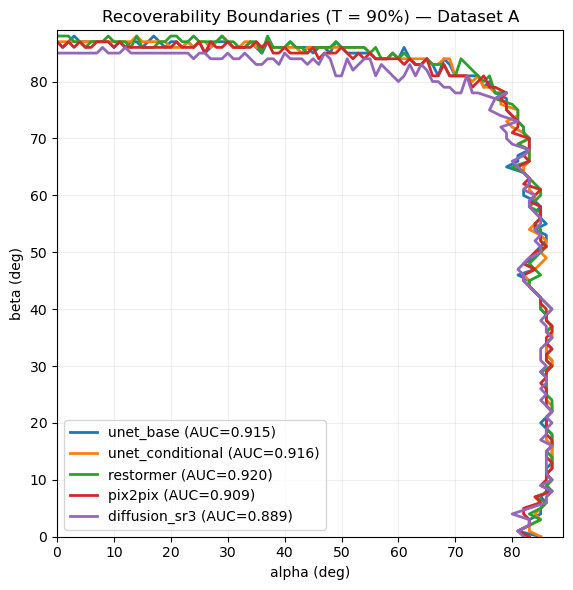

In [4]:
import matplotlib.pyplot as plt

# Set the threshold for ocr plate success
T = 0.9

# Filter to Dataset A only
df_A = df_mean[df_mean["dataset"] == "A"]

fig, ax = plt.subplots(figsize=(6, 6))

# Plot each model’s boundary for Dataset A
for model in model_names:
    df_model = df_A[df_A["model"] == model]
    boundary, auc_score = compute_recoverability_boundary_and_auc(df_model, T)
    alpha_pts, beta_pts = zip(*boundary)
    ax.plot(alpha_pts, beta_pts, linewidth=2, label=f"{model} (AUC={auc_score:.3f})")

ax.grid(True, alpha=0.2)
ax.set_xlabel("alpha (deg)")
ax.set_ylabel("beta (deg)")
ax.set_title(f"Recoverability Boundaries (T = {int(T*100)}%) — Dataset A")
ax.set_xlim(0, 89)
ax.set_ylim(0, 89)
ax.set_aspect("equal", "box")
ax.legend(loc="lower left", fontsize="medium", ncol=1)
plt.tight_layout()
plt.show()

######################################################################################  
All datasets combined  
###################################################################################### 

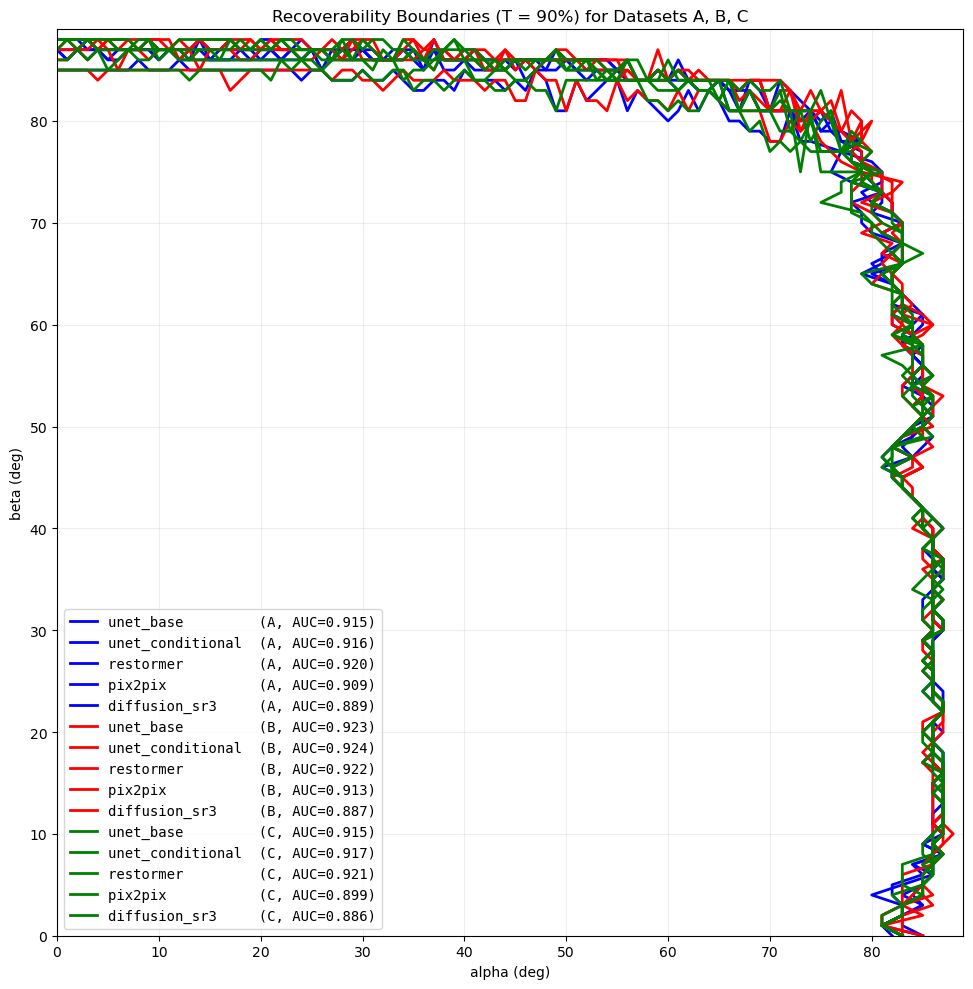

In [5]:
import matplotlib.pyplot as plt

T = 0.9

fig, ax = plt.subplots(figsize=(10, 10))

# Loop over datasets and models using the single df_mean
for ds in datasets:
    # filter df_mean by dataset
    df_mean_ds = df_mean[df_mean["dataset"] == ds]
    for model in model_names:
        # filter to this model
        df_model = df_mean_ds[df_mean_ds["model"] == model]
        # compute boundary and AUC
        boundary, auc_score = compute_recoverability_boundary_and_auc(df_model, T)
        alpha_vals, beta_vals = zip(*boundary)
        # plot
        ax.plot(
            alpha_vals, beta_vals, color=colors[ds], linewidth=2, label=f"{model.ljust(17)} ({ds}, AUC={auc_score:.3f})"
        )

# axis labels & title
ax.set_xlabel("alpha (deg)")
ax.set_ylabel("beta (deg)")
ax.set_title(f"Recoverability Boundaries (T = {int(T*100)}%) for Datasets A, B, C")

# limits, aspect, grid, legend
ax.set_xlim(0, 89)
ax.set_ylim(0, 89)
ax.set_aspect("equal", "box")
ax.grid(alpha=0.2)
ax.legend(loc="lower left", fontsize="medium", prop={"family": "monospace"})

plt.tight_layout()
plt.show()

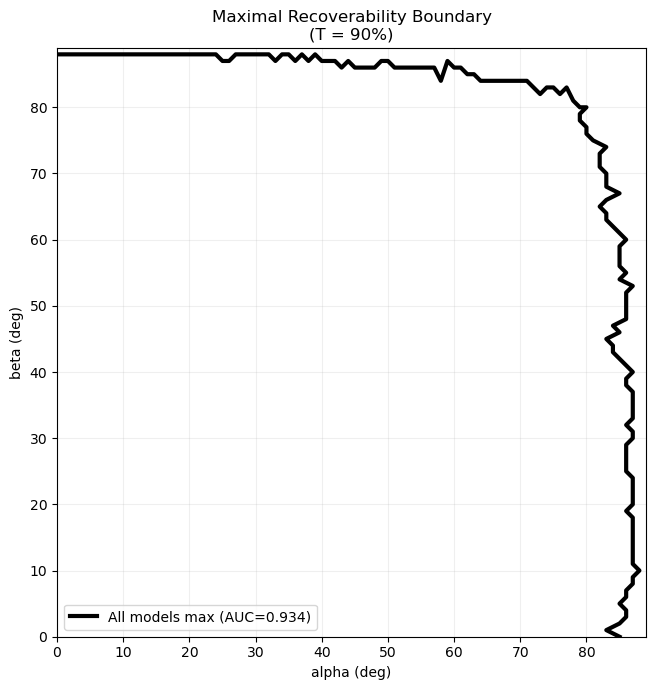

In [6]:
import matplotlib.pyplot as plt

# Maximal Recoverability boundary across all models & datasets
# pointwise maximum plate_pass over (alpha,beta)
union = df_mean.groupby(["alpha", "beta"], as_index=False)["ocr_plate"].max()
upper_boundary, max_auc = compute_recoverability_boundary_and_auc(union, T)
ua, ub = zip(*upper_boundary)

fig, ax = plt.subplots(figsize=(7, 7))

ax.plot(ua, ub, color="black", linewidth=3, label=f"All models max (AUC={max_auc:.3f})")
ax.set_title(f"Maximal Recoverability Boundary\n(T = {int(T*100)}%)")
ax.set_xlabel("alpha (deg)")
ax.set_ylabel("beta (deg)")
ax.set_xlim(0, 89)
ax.set_ylim(0, 89)
ax.set_aspect("equal", "box")
ax.grid(alpha=0.2)
ax.legend(loc="lower left", fontsize="medium")

plt.tight_layout()
plt.show()

######################################################################################  
AUC and reliability  
###################################################################################### 

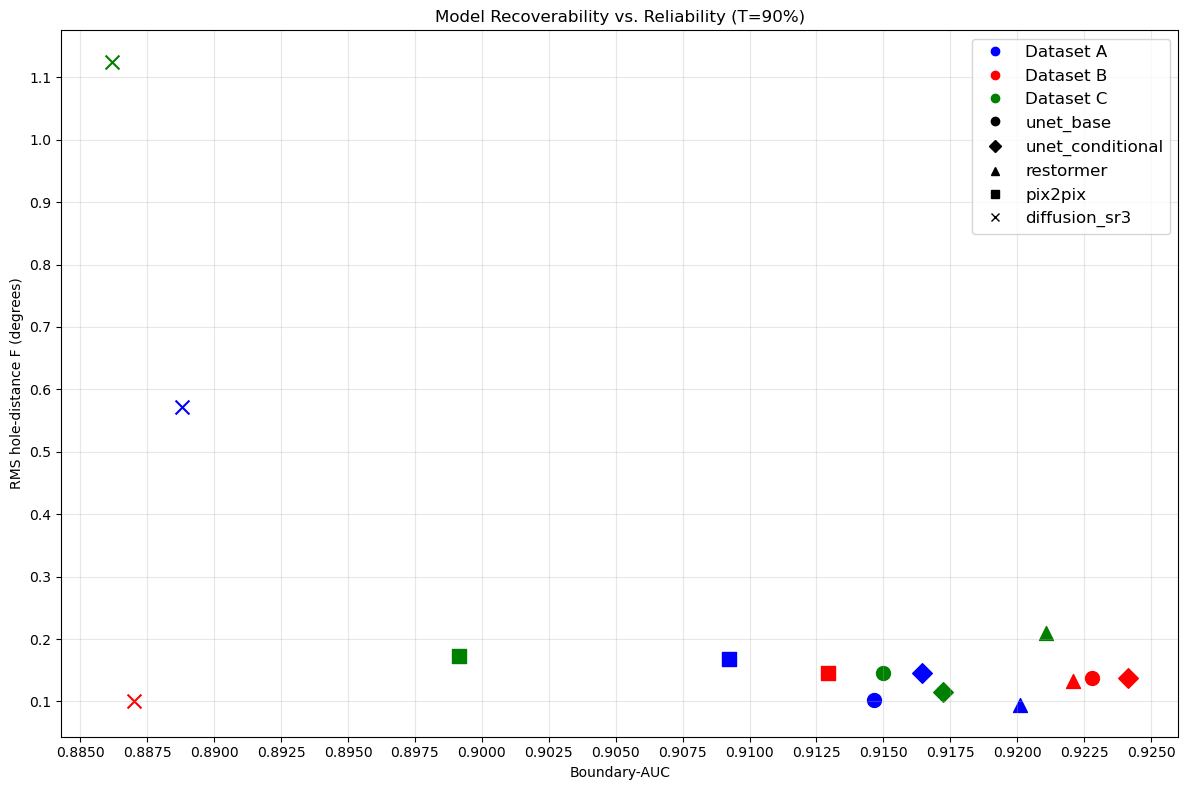

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

T = 0.9

markers = {
    "unet_base": "o",
    "unet_conditional": "D",
    "restormer": "^",
    "pix2pix": "s",
    "diffusion_sr3": "x",
}

alpha_vals = np.arange(90)
beta_vals = np.arange(90)
grid_area = 89 * 89

def compute_auc_and_F(df, T):
    pivot = df.pivot(index="beta", columns="alpha", values="ocr_plate").reindex(
        index=beta_vals, columns=alpha_vals, fill_value=0
    )
    rec = (pivot.values >= T).astype(int)
    beta_max = [beta_vals[rec[:, j] == 1].max() if rec[:, j].any() else 0 for j in range(90)]
    alpha_max = [alpha_vals[rec[i, :] == 1].max() if rec[i, :].any() else 0 for i in range(90)]
    boundary = []
    for a, b in zip(alpha_vals, beta_max):
        if b >= a:
            boundary.append((a, b))
    for b, a in zip(beta_vals[::-1], alpha_max[::-1]):
        if a >= b:
            boundary.append((a, b))
    auc_bxa = np.trapz(beta_max, x=alpha_vals)
    auc_axb = np.trapz(alpha_max, x=beta_vals)
    auc = 0.5 * (auc_bxa + auc_axb) / grid_area
    beta_max_arr = np.array(beta_max)
    alpha_max_arr = np.array(alpha_max)
    A, B = np.meshgrid(alpha_vals, beta_vals)
    inside = (B <= beta_max_arr[np.newaxis, :]) & (A <= alpha_max_arr[:, np.newaxis])
    b_arr = np.array(boundary)
    holes = np.argwhere(inside & (rec == 0))
    d2 = []
    for i, j in holes:
        pt = np.array([alpha_vals[j], beta_vals[i]])
        d2.append(np.min(np.sum((b_arr - pt) ** 2, axis=1)))
    E = 0.5 * (sum(beta_max) + sum(alpha_max))
    F = np.sqrt(np.sum(d2) / E) if d2 else 0.0
    return auc, F

# Collect AUC and F for all model-dataset pairs
results = []
for ds in datasets:
    for model in model_names:
        df_md = df_mean[(df_mean.dataset == ds) & (df_mean.model == model)]
        auc, F = compute_auc_and_F(df_md, T)
        results.append({"dataset": ds, "model": model, "AUC": auc, "F": F})

res_df = pd.DataFrame(results)

# Plot scatter AUC vs F
fig, ax = plt.subplots(figsize=(12, 8))
for _, row in res_df.iterrows():
    ax.scatter(
        row["AUC"],
        row["F"],
        color=colors[row["dataset"]],
        marker=markers[row["model"]],
        s=100,
        label=f'{row["model"]} (DS {row["dataset"]})',
    )

# Custom legend: one per dataset (color) and per model (marker)
handles = []
for ds in datasets:
    handles.append(plt.Line2D([], [], color=colors[ds], marker="o", linestyle="", label=f"Dataset {ds}"))
for model in model_names:
    handles.append(plt.Line2D([], [], color="k", marker=markers[model], linestyle="", label=model))
ax.legend(handles=handles, loc="upper right", fontsize="large")

ax.set_xlabel("Boundary-AUC")
ax.set_ylabel("RMS hole-distance F (degrees)")
ax.set_title(f"Model Recoverability vs. Reliability (T={int(T*100)}%)")
ax.grid(alpha=0.3)
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
ax.yaxis.set_major_locator(MaxNLocator(nbins=14))
plt.tight_layout()
plt.show()


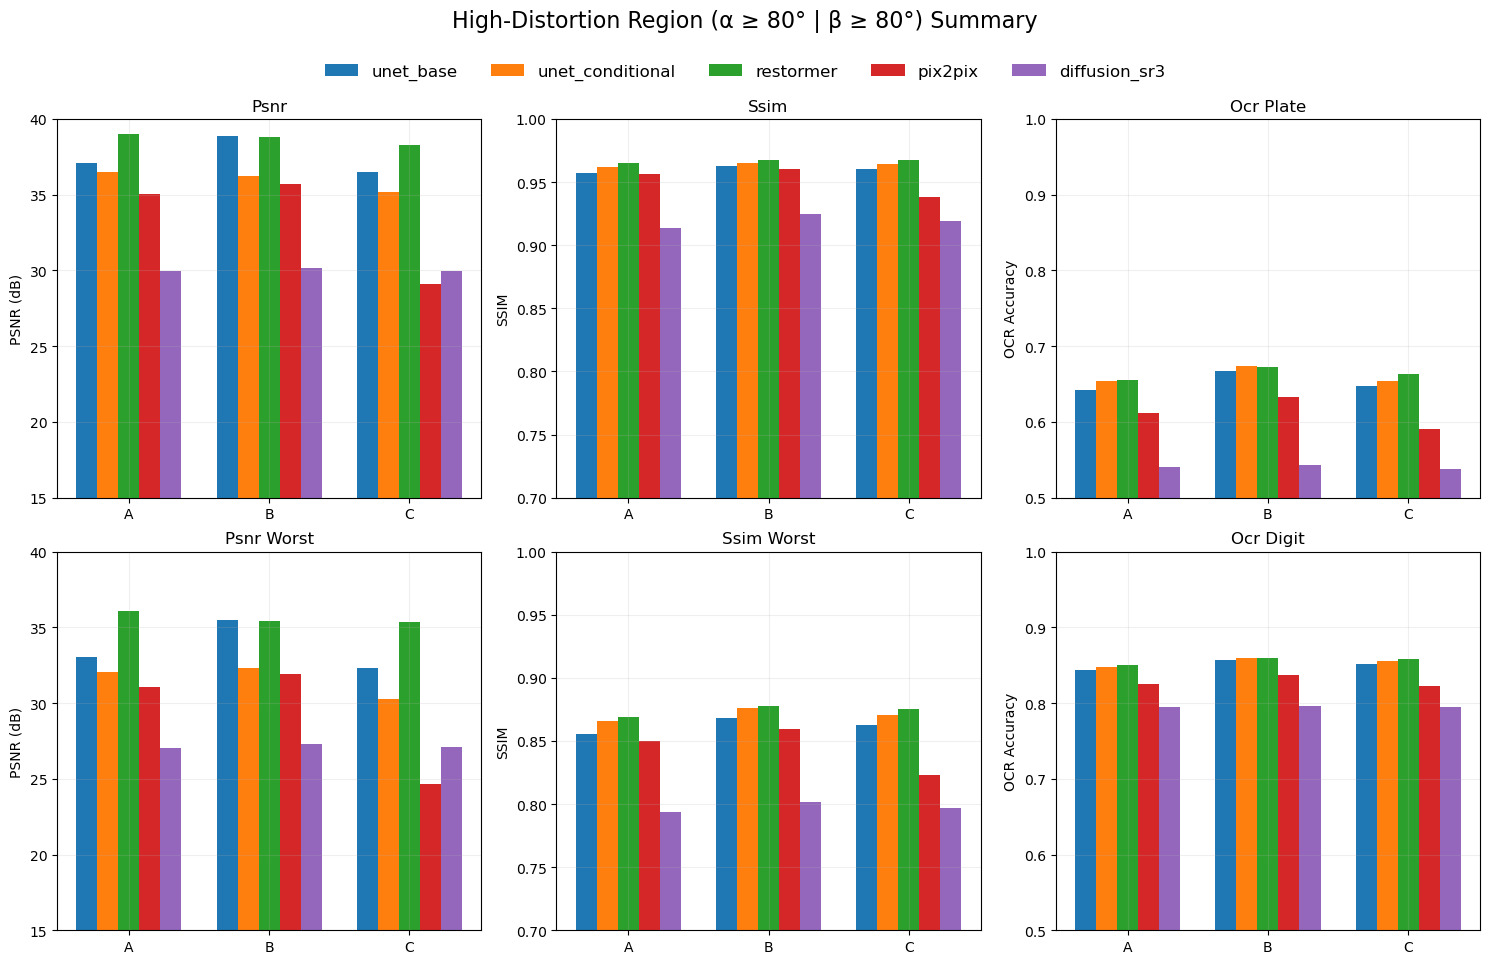

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


mask = (df_mean.alpha >= 80) | (df_mean.beta >= 80)
df_R = df_mean[mask]

summary = df_R.groupby(["model", "dataset"], observed=True)[metrics].mean()

# build a MultiIndex in that order and re-index summary
idx = pd.MultiIndex.from_product([model_names, datasets], names=["model", "dataset"])
summary = summary.reindex(idx)

# colour palette
cmap = plt.get_cmap("tab10")
model_colors = {m: cmap(i) for i, m in enumerate(model_names)}

metrics_by_col = [
    ["psnr", "psnr_worst"],
    ["ssim", "ssim_worst"],
    ["ocr_plate", "ocr_digit"],
]

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True)
fig.suptitle("High-Distortion Region (α ≥ 80° | β ≥ 80°) Summary", fontsize=16, y=0.96)

x = np.arange(len(datasets))  # positions for A, B, C
width = 0.15
n_mdl = len(model_names)

for col_idx, (m0, m1) in enumerate(metrics_by_col):
    for row_idx, metric in enumerate([m0, m1]):
        ax = axes[row_idx, col_idx]

        for i, model in enumerate(model_names):
            offset = (i - (n_mdl - 1) / 2) * width
            vals = [summary.loc[(model, ds), metric] for ds in datasets]
            ax.bar(x + offset, vals, width=width, color=model_colors[model], label=model)

        ax.set_xticks(x)
        ax.set_xticklabels(datasets)
        ax.set_title(metric.replace("_", " ").title())
        ax.grid(alpha=0.2)

        # axis limits / labels
        if "psnr" in metric:
            ax.set_ylim(15, 40)
            ax.set_ylabel("PSNR (dB)")
        elif "ssim" in metric:
            ax.set_ylim(0.7, 1.0)
            ax.set_ylabel("SSIM")
        else:
            ax.set_ylim(0.5, 1.0)
            ax.set_ylabel("OCR Accuracy")

for ax in axes[0, :]:
    ax.tick_params(labelbottom=True)

# single legend above all plots
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    ncol=len(model_names),
    bbox_to_anchor=(0.5, 0.92),
    frameon=False,
    fontsize="large",
)

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

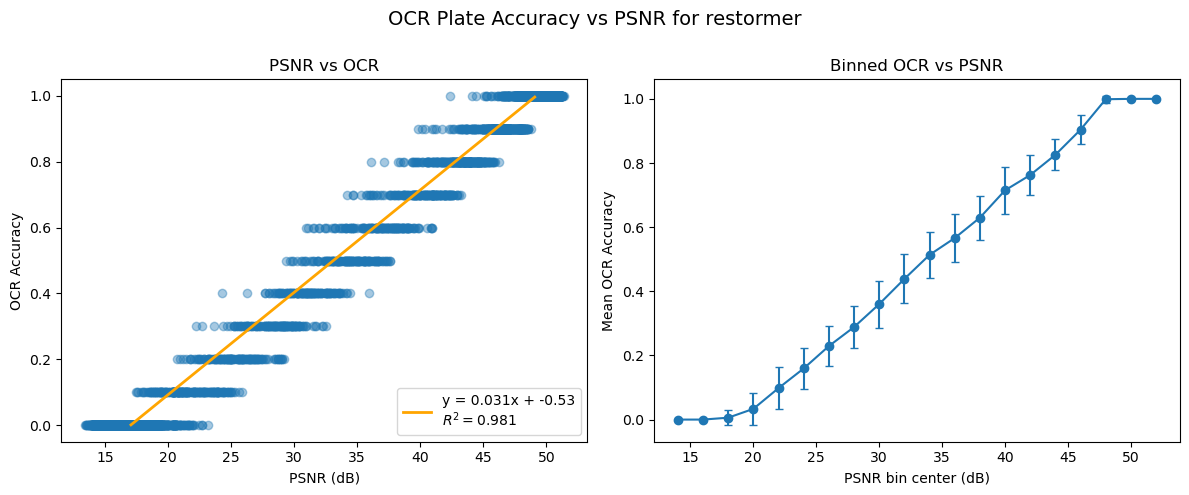

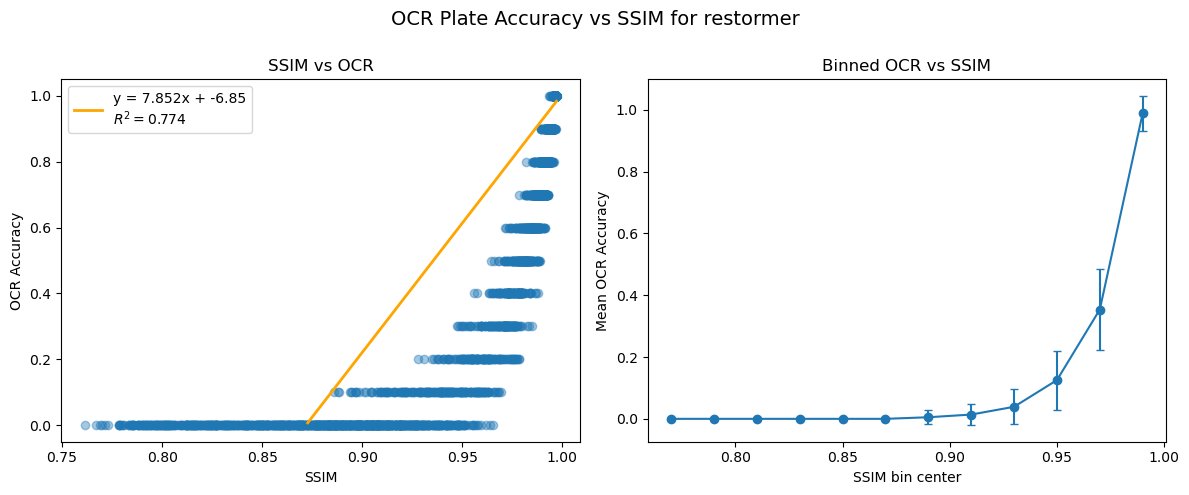

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Define the model to analyze
model_name = "restormer"

# Filter to the selected model
df_rst = df_mean[df_mean["model"] == model_name].copy()

# Common y
y = df_rst["ocr_plate"]

# --- PSNR vs OCR ---
x_psnr = df_rst["psnr"]
m_psnr, b_psnr = np.polyfit(x_psnr, y, 1)
y_pred_psnr = m_psnr * x_psnr + b_psnr
r2_psnr = r2_score(y, y_pred_psnr)

# Create PSNR line and clip to [0,1]
xx_psnr = np.linspace(x_psnr.min(), x_psnr.max(), 200)
yy_psnr = m_psnr * xx_psnr + b_psnr
mask_psnr = (yy_psnr >= 0) & (yy_psnr <= 1)
xx_psnr_plot = xx_psnr[mask_psnr]
yy_psnr_plot = yy_psnr[mask_psnr]

# PSNR binned stats (2 dB bins)
bins_psnr = np.arange(np.floor(x_psnr.min()), np.ceil(x_psnr.max()) + 2, 2)
df_rst["psnr_bin"] = pd.cut(x_psnr, bins_psnr)
psnr_stats = df_rst.groupby("psnr_bin", observed=True)["ocr_plate"].agg(mean="mean", std="std").reset_index()
psnr_stats["center"] = psnr_stats["psnr_bin"].apply(lambda iv: iv.left + iv.length / 2)

# --- SSIM vs OCR ---
x_ssim = df_rst["ssim"]
m_ssim, b_ssim = np.polyfit(x_ssim, y, 1)
y_pred_ssim = m_ssim * x_ssim + b_ssim
r2_ssim = r2_score(y, y_pred_ssim)

# Create SSIM line and clip to [0,1]
xx_ssim = np.linspace(x_ssim.min(), x_ssim.max(), 200)
yy_ssim = m_ssim * xx_ssim + b_ssim
mask_ssim = (yy_ssim >= 0) & (yy_ssim <= 1)
xx_ssim_plot = xx_ssim[mask_ssim]
yy_ssim_plot = yy_ssim[mask_ssim]

# SSIM binned stats (0.02 bins)
bins_ssim = np.arange(np.floor(x_ssim.min() * 100) / 100, np.ceil(x_ssim.max() * 100) / 100 + 0.02, 0.02)
df_rst["ssim_bin"] = pd.cut(x_ssim, bins_ssim)
ssim_stats = df_rst.groupby("ssim_bin", observed=True)["ocr_plate"].agg(mean="mean", std="std").reset_index()
ssim_stats["center"] = ssim_stats["ssim_bin"].apply(lambda iv: iv.left + iv.length / 2)

# --- Plotting PSNR ---
fig1, axes1 = plt.subplots(1, 2, figsize=(12, 5))
fig1.suptitle(f"OCR Plate Accuracy vs PSNR for {model_name}", fontsize="14")

# PSNR scatter + clipped fit
ax = axes1[0]
ax.scatter(x_psnr, y, alpha=0.4)
ax.plot(
    xx_psnr_plot, yy_psnr_plot, color="orange", lw=2, label=f"y = {m_psnr:.3f}x + {b_psnr:.2f}\n$R^2={r2_psnr:.3f}$"
)
ax.set_xlabel("PSNR (dB)")
ax.set_ylabel("OCR Accuracy")
ax.set_title("PSNR vs OCR")
ax.legend(loc="lower right")

# PSNR binned
ax = axes1[1]
ax.errorbar(psnr_stats["center"], psnr_stats["mean"], yerr=psnr_stats["std"], fmt="o-", capsize=3)
ax.set_xlabel("PSNR bin center (dB)")
ax.set_ylabel("Mean OCR Accuracy")
ax.set_title("Binned OCR vs PSNR")

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


# --- Plotting SSIM ---
fig2, axes2 = plt.subplots(1, 2, figsize=(12, 5))
fig2.suptitle(f"OCR Plate Accuracy vs SSIM for {model_name}", fontsize="14")

# SSIM scatter + clipped fit
ax = axes2[0]
ax.scatter(x_ssim, y, alpha=0.4)
ax.plot(
    xx_ssim_plot, yy_ssim_plot, color="orange", lw=2, label=f"y = {m_ssim:.3f}x + {b_ssim:.2f}\n$R^2={r2_ssim:.3f}$"
)
ax.set_xlabel("SSIM")
ax.set_ylabel("OCR Accuracy")
ax.set_title("SSIM vs OCR")
ax.legend(loc="upper left")

# SSIM binned
ax = axes2[1]
ax.errorbar(ssim_stats["center"], ssim_stats["mean"], yerr=ssim_stats["std"], fmt="o-", capsize=3)
ax.set_xlabel("SSIM bin center")
ax.set_ylabel("Mean OCR Accuracy")
ax.set_title("Binned OCR vs SSIM")

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()